# Prova 2 - Módulo de Probabilidade e Estatística (PEDS Itaú)

## Fellipe Premazzi Rego
02/10/2019

## 1 - Séries temporais e previsão

Modelar cada um dos cinco intervalos da série temporal do número de movimentações planejadas de aeronaves no aeroporto de Congonhas

In [2]:
library(forecast)
library(TTR)
library(stats)
library(seasonal)
library(timeDate)
library(tseries)
library(moments)
library(nortest)
library(AnalyzeTS)
library(ggplot2)
library(rugarch)

In [3]:
movimentacoes <- read.table("dados.csv",sep = ";" , header = TRUE)
names(movimentacoes) = c("data", "total")
movimentacoes$data <- as.Date(movimentacoes$data, '%d/%m/%y')
head(movimentacoes)

data,total
2000-01-01,356
2000-01-02,483
2000-01-03,568
2000-01-04,559
2000-01-05,552
2000-01-06,543


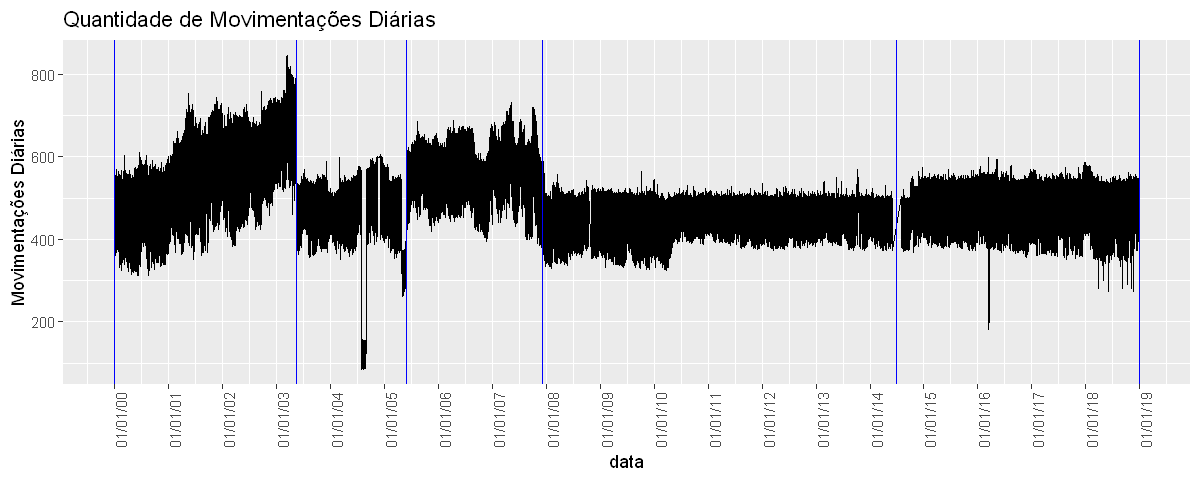

In [5]:
ggplot(movimentacoes, aes(data, total)) + geom_line() + 
    scale_x_date(date_labels = "%d/%m/%y", date_breaks = "1 year") + 
    ylab("Movimentações Diárias") + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    ggtitle("Quantidade de Movimentações Diárias") +
    geom_vline(xintercept = as.numeric(as.Date("2000-01-01")), color = "blue") +
    geom_vline(xintercept = as.numeric(as.Date("2003-05-15")), color = "blue") +
    geom_vline(xintercept = as.numeric(as.Date("2005-06-01")), color = "blue") +
    geom_vline(xintercept = as.numeric(as.Date("2007-12-10")), color = "blue") +
    geom_vline(xintercept = as.numeric(as.Date("2014-07-01")), color = "blue") +
    geom_vline(xintercept = as.numeric(as.Date("2019-01-01")), color = "blue") 
options(repr.plot.width=10, repr.plot.height=4)

Os dados foram separados em 5 janelas, sendo essas:
- 1ª Janela - A partir de 01/01/2000 até 15/05/2003 (exclusivo)
- 2ª Janela - A partir de 15/05/2003 até 01/06/2005 (exclusivo)
- 3ª Janela - A partir de 01/06/2005 até 10/12/2007 (exclusivo)
- 4ª Janela - A partir de 10/12/2007 até 01/07/2014 (exclusivo)
- 5ª Janela - A partir de 01/07/2014 até 01/01/2019 (inclusivo)

In [6]:
mov1 <- subset(movimentacoes, data < as.Date("2003-05-15"))
mov2 <- subset(movimentacoes, 
               as.Date("2003-05-15") <= data & data < as.Date("2005-06-01"))
mov3 <- subset(movimentacoes, 
               as.Date("2005-06-01") <= data & data < as.Date("2007-12-10"))
mov4 <- subset(movimentacoes, 
               as.Date("2007-12-10") <= data & data < as.Date("2014-07-01"))
mov5 <- subset(movimentacoes, 
               as.Date("2014-07-01") <= data)

### Particionamento de treino e teste

In [7]:
freq = 7

- #### 1ª janela

In [8]:
mov1.ts = ts(mov1$total, frequency = freq)

w1 = nrow(mov1[trunc(nrow(mov1)*0.9+1):nrow(mov1),])

mov1.treino.ts = head(mov1.ts, round(length(mov1.ts)*0.9))
mov1.teste.ts = tail(mov1.ts, w1)

- #### 2ª janela

In [9]:
mov2.ts = ts(mov2$total, frequency = freq)

w2 = nrow(mov2[trunc(nrow(mov2)*0.9+1):nrow(mov2),])

mov2.treino.ts = head(mov2.ts, round(length(mov2.ts)*0.9))
mov2.teste.ts = tail(mov2.ts, w2)

- #### 3ª janela

In [10]:
mov3.ts = ts(mov3$total, frequency = freq)

w3 = nrow(mov3[trunc(nrow(mov3)*0.9+1):nrow(mov3),])

mov3.treino.ts = head(mov3.ts, round(length(mov3.ts)*0.9))
mov3.teste.ts = tail(mov3.ts, w3)

- #### 4ª janela

In [11]:
mov4.ts = ts(mov4$total, frequency = freq)

w4 = nrow(mov4[trunc(nrow(mov4)*0.9+1):nrow(mov4),])

mov4.treino.ts = head(mov4.ts, round(length(mov4.ts)*0.9))
mov4.teste.ts = tail(mov4.ts, w4)

- #### 5ª janela

In [12]:
mov5.ts = ts(mov5$total, frequency = freq)

w5 = nrow(mov5[trunc(nrow(mov5)*0.9+1):nrow(mov5),])

mov5.treino.ts = head(mov5.ts, round(length(mov5.ts)*0.9))
mov5.teste.ts = tail(mov5.ts, w5)

### 1) Holt-Winters

O algoritmo Holt-Winters é uma das técnicas de previsão mais populares para séries temporais. Apesar de existir há décadas, ele ainda é muito utilizado em aplicativos voltados para fins de detecção de anomalias e, especialmente, na previsão de tempo.

Esse modelo é uma extensão do modelo de Holt (suavização exponencial dupla), desenvolvido por Winter. A sua capacidade de previsão é simples, mas muito poderosa. Ele pode lidar com muitos padrões sazonais complicados, simplesmente encontrando o valor central e adicionando os efeitos de inclinação e sazonalidade.

#### Método de Holt-Winters para série com tendência e sazonalidade  

Quando a sério temporal apresenta tendência para a projeção deve ser utilizada uma técnica que considere essa componente. Nesse moedelo, além do coeficiente de amortecimento $\alpha$, um coeficiente representando a tendência $\beta$ é adicionado.

Em primeiro lugar, é necessário escolher um $\alpha$ respeitando o intervalo [0,1]. Então, calcula-se $N_{t}$, nível da série no instante t, conforme a equação abaixo:

$$N_{t} = \alpha(N_{t-1}+T_{t-1}) + (1- \alpha)y_{t}, onde\;  0<\alpha<1$$

Calcudo o $N_t$, é possível então prosseguri para o cálculo do $T_t$:

$$T_{t} = \beta.T_{t-1} + (1- \beta)(N_{t}-N_{t-1}), onde\;  0<\beta<1$$

Por fim, realiza-se a previsão $\hat{y}_{n+h}$ em h períodos à frente da previsão:

$$\hat{y}_{n+h} = N_{n} + hT_{n}, \; com\; h=1,2,3,4..H$$

Sendo:
- $N_t$ ... nível da sério no instante "t"
- $\alpha$ ... coeficiente de amortecimento para flutuações aleatórias
- $T_t$ ... tendência da série no instante "t"
- $y_t$ ... valor da série no instante "t"
- $\beta$ ... coeficiente associado à tendência
- $h$ ... períodos à frente para obter a previsão
- $\hat{y}_{n+h}$ ... previsão h períodos
- $n$ ... número de observações da série

#### Método de Holt-Winters para série com tendência sem sazonalidade

Quando a série temporal apresenta tendência e sazonalidade, o método de Holt-Winters para série comtendência e sazonalidade é miuto adequado (quando se dispõe de séries compoucos valores). Para realizar, uma para a tendência e uma oara a sazonalidade. Essas equações são apresentadas a seguir.

- Multiplicativo

Em primeiro lugar, é necessário escolher um $\alpha, \beta, \gamma$ respeitando o intervalo [0,1]. Então, calcula-se $N_{s}$, nível da série no instante t, conforme a equação abaixo:

$$N_{s}=\frac{1}{s}\sum_{i=1}^{s}y_{i}$$

Calcudo o $N_s$, é possível então prosseguri para o cálculo do $T_s$:

$$ T_{s}= \frac{1}{s}\Bigg[\frac{y_{s+1}-y_{1}}{s}+\frac{y_{s+2}-y_{2}}{s}+...+\frac{y_{2s}-y_{s}}{s}\Bigg]$$

Calcudo o $T_s$, é possível então prosseguir para o cálculo do $S_i$:

$$ S_{i}=\frac{y_{i}}{N_{s}},\;\;i=1,...,s $$

Cáculo para $t>s$:

$$ N_{t} = (1-\alpha)(N_{t-1}+T_{t-1})+\alpha\left(\frac{y_{t}}{S_{t-s}}\right ), \;com \; 0<\alpha<1$$

Calcudo o $N_t$, é possível então prosseguri para o cálculo do $T_t$:

$$ T_{t} = (1-\beta) T_{t-1} + \beta(N_{t}-N_{t-1}),\;com\; 0<\beta<1$$

Então, a sazonalidade ($S_{t}$) no instante t é calculada por:

$$ S_{t} = (1-\gamma) S_{t-1}+\gamma\big(\frac{y_{t}}{N_{t}}\big),\; com \; 0<\gamma<1 $$

Para concluir, é construída a previsão, onde $S$ é a variação sazonal, $s$ é o número de períodos e $\gamma$ é o coeficiente de sazonalidade.

$$ \hat{y}_{n+h} = (N_{n} + hT_{n})S_{n+h-s}, \; com \; h=1,2,3,4...,s$$

Sendo:
- $N_t$ ... nível da sério no instante "t"
- $\alpha$ ... coeficiente de amortecimento para flutuações aleatórias
- $T_t$ ... tendência da série no instante "t"
- $y_t$ ... valor da série no instante "t"
- $\beta$ ... coeficiente associado à tendência
- $S_t$ ... fator de sazonalidade
- $\gamma$ ... coeficiente associado a sazonalidade
- $s$ ... número de períodos da série (dados trimestrais s=4, anuais s=12)
- $h$ ... períodos à frente para obter a previsão
- $\hat{y}_{n+h}$ ... previsão h períodos
- $n$ ... número de observações da série

- Aditivo

Em primeiro lugar, é necessário escolher um $\alpha, \beta, \gamma$ respeitando o intervalo [0,1]. Então, calcula-se $N_{s}$, nível da série no instante t, conforme a equação abaixo:

$$N_{s}=\frac{1}{s}\sum_{i=1}^{s}y_{i}$$

Calcudo o $N_s$, é possível então prosseguri para o cálculo do $T_s$:

$$ T_{s}= \frac{1}{s}\Bigg[\frac{y_{s+1}-y_{1}}{s}+\frac{y_{s+2}-y_{2}}{s}+...+\frac{y_{2s}-y_{s}}{s}\Bigg]$$

Calcudo o $T_s$, é possível então prosseguir para o cálculo do $S_i$:

$$ S_{i}=y_{i}-N_{s},\;\;i=1,...,s $$

Cáculo para $t>s$:

$$ N_{t} = (1-\alpha)(N_{t-1}+T_{t-1})+\alpha\left(y_{t}-S_{t-s}\right), \;com \; 0<\alpha<1$$

Calcudo o $N_t$, é possível então prosseguri para o cálculo do $T_t$:

$$ T_{t} = (1-\beta) T_{t-1} + \beta(N_{t}-N_{t-1}),\;com\; 0<\beta<1$$

Então, a sazonalidade ($S_{t}$) no instante t é calculada por:

$$ S_{t} = (1-\gamma) S_{t-s}+\gamma\big(y_{t}-N_{t}\big),\; com \; 0<\gamma<1 $$

Para concluir, é construída a previsão, onde $S$ é a variação sazonal, $s$ é o número de períodos e $\gamma$ é o coeficiente de sazonalidade.

$$ \hat{y}_{n+h} = N_{n} + hT_{n} + S_{n+h-s}, \; com \; h=1,2,3,4...,s$$

Sendo:
- $N_t$ ... nível da sério no instante "t"
- $\alpha$ ... coeficiente de amortecimento para flutuações aleatórias
- $T_t$ ... tendência da série no instante "t"
- $y_t$ ... valor da série no instante "t"
- $\beta$ ... coeficiente associado à tendência
- $S_t$ ... fator de sazonalidade
- $\gamma$ ... coeficiente associado a sazonalidade
- $s$ ... número de períodos da série (dados trimestrais s=4, anuais s=12)
- $h$ ... períodos à frente para obter a previsão
- $\hat{y}_{n+h}$ ... previsão h períodos
- $n$ ... número de observações da série

- #### 1ª janela

In [13]:
hw.mov1.forecast = HoltWinters(mov1.treino.ts)

In [14]:
hw.mov1.predict <- forecast(hw.mov1.forecast,h = w1)#, prediction.interval = TRUE, level = 0.95)

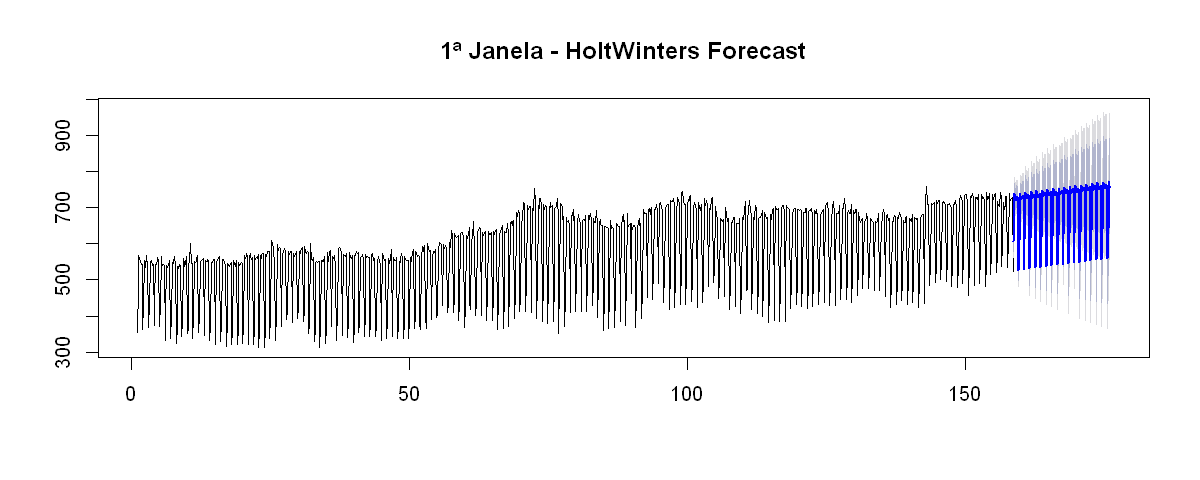

In [15]:
plot(hw.mov1.predict, main = "1ª Janela - HoltWinters Forecast")

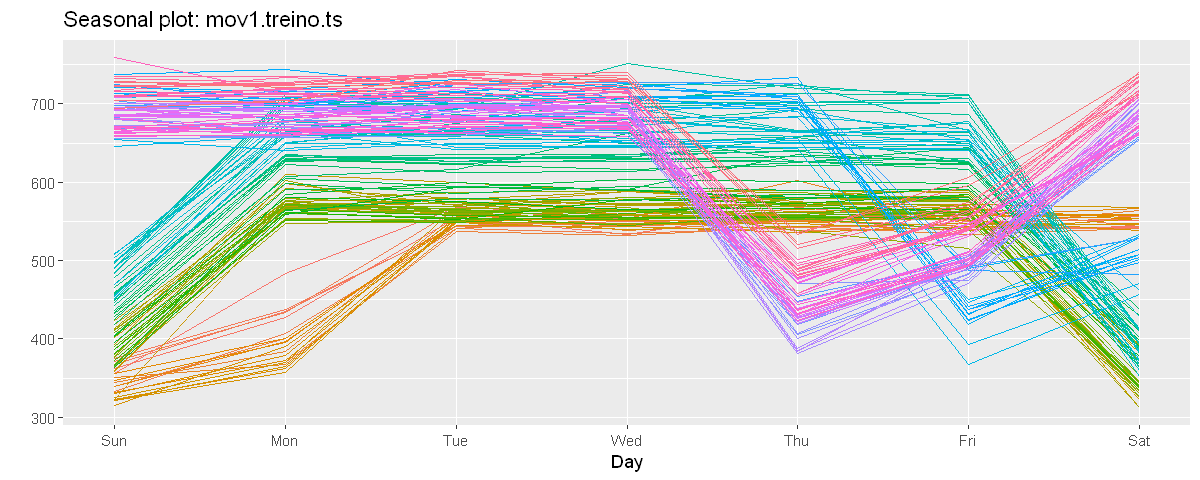

In [16]:
ggseasonplot(mov1.treino.ts) + theme(legend.position = "none") 

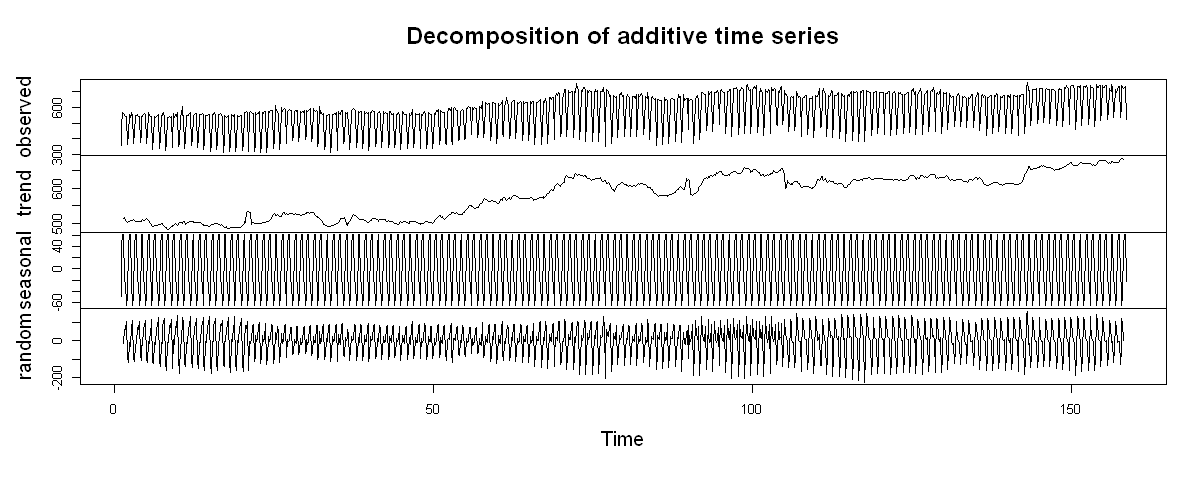

In [17]:
plot(decompose(mov1.treino.ts))

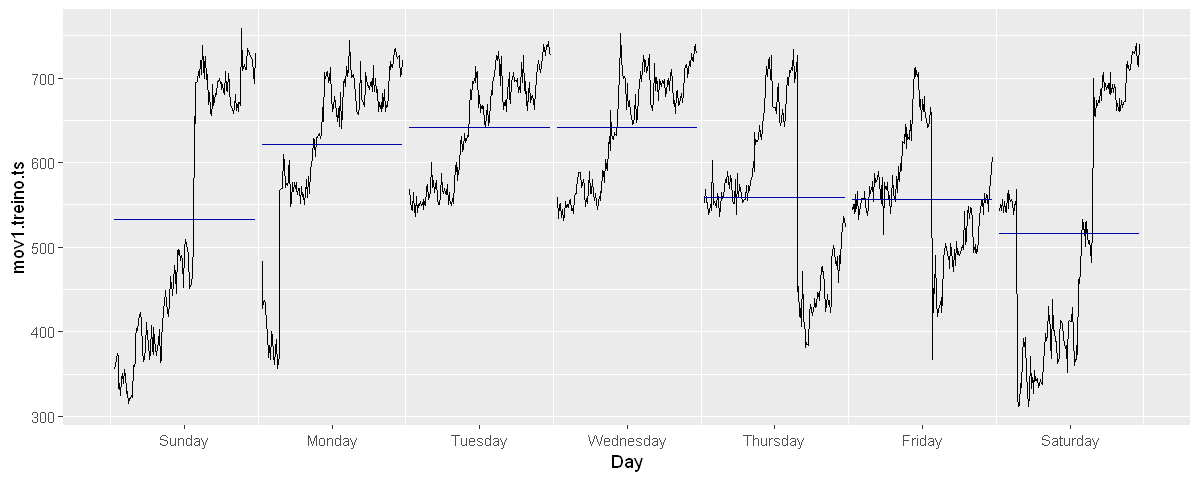

In [18]:
ggsubseriesplot(mov1.treino.ts)

In [19]:
accuracy(hw.mov1.predict, mov1.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,1.004348,24.13730,14.14988,0.07035205,2.635675,0.9828047,0.2014666,NA
Test set,8.380564,38.26821,28.02631,0.62369195,3.987654,1.9466166,0.6471415,0.3284734


- #### 2ª janela

In [20]:
hw.mov2.forecast = HoltWinters(mov2.treino.ts)

In [21]:
hw.mov2.predict <- predict(hw.mov2.forecast,n.ahead = w2, prediction.interval = TRUE, level = 0.95)

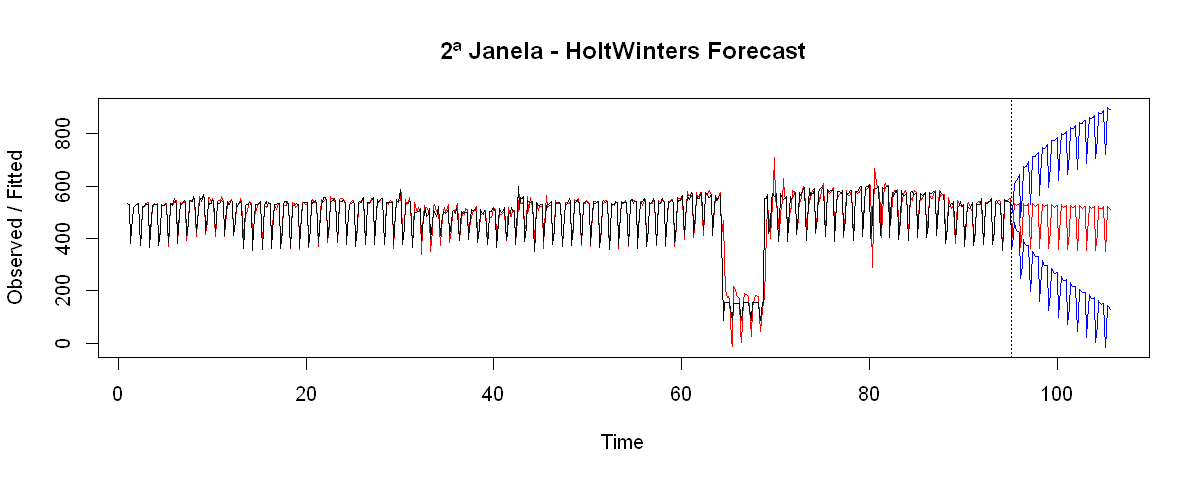

In [22]:
plot(hw.mov2.forecast, hw.mov2.predict, main = "2ª Janela - HoltWinters Forecast")

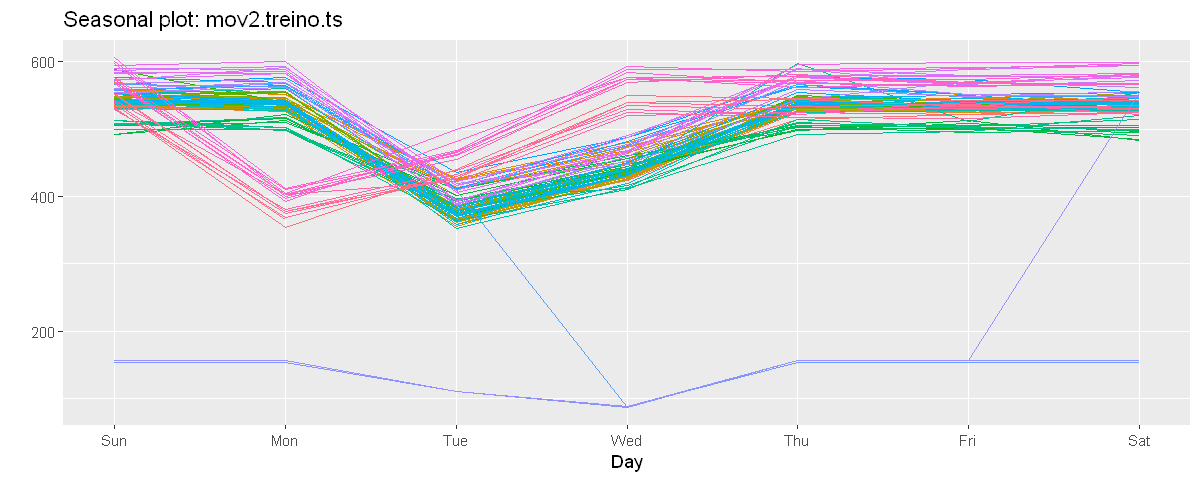

In [23]:
ggseasonplot(mov2.treino.ts) + theme(legend.position = "none") 

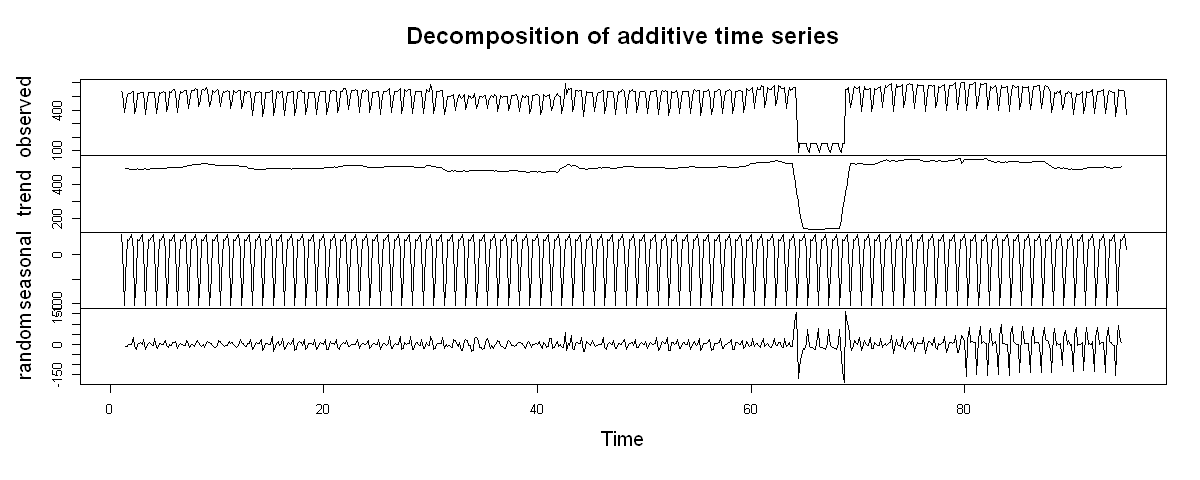

In [24]:
plot(decompose(mov2.treino.ts))

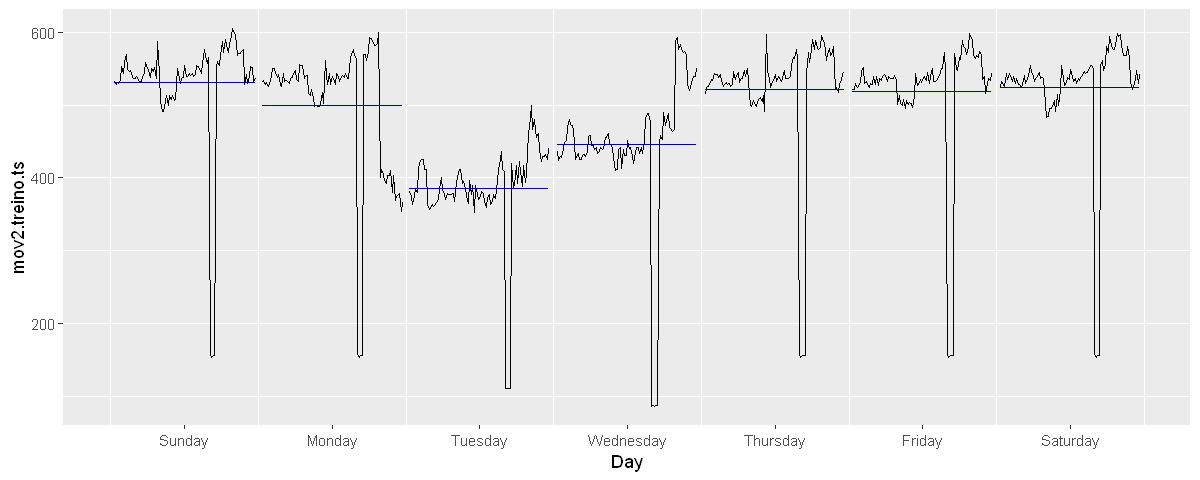

In [25]:
ggsubseriesplot(mov2.treino.ts)

In [26]:
accuracy(hw.mov2.predict, mov2.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-51.13775,92.3236,66.46005,-15.60363,18.57117,0.8923238,1.661269


- #### 3ª janela

In [27]:
hw.mov3.forecast = HoltWinters(mov3.treino.ts)

In [28]:
hw.mov3.predict <- predict(hw.mov3.forecast,n.ahead = w3, prediction.interval = TRUE, level = 0.95)

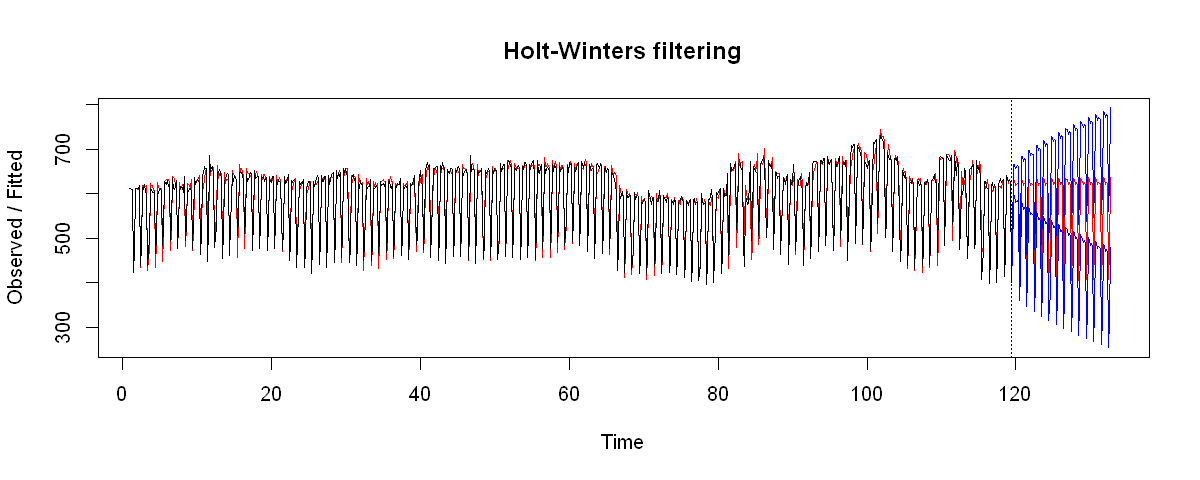

In [29]:
plot(hw.mov3.forecast, hw.mov3.predict)

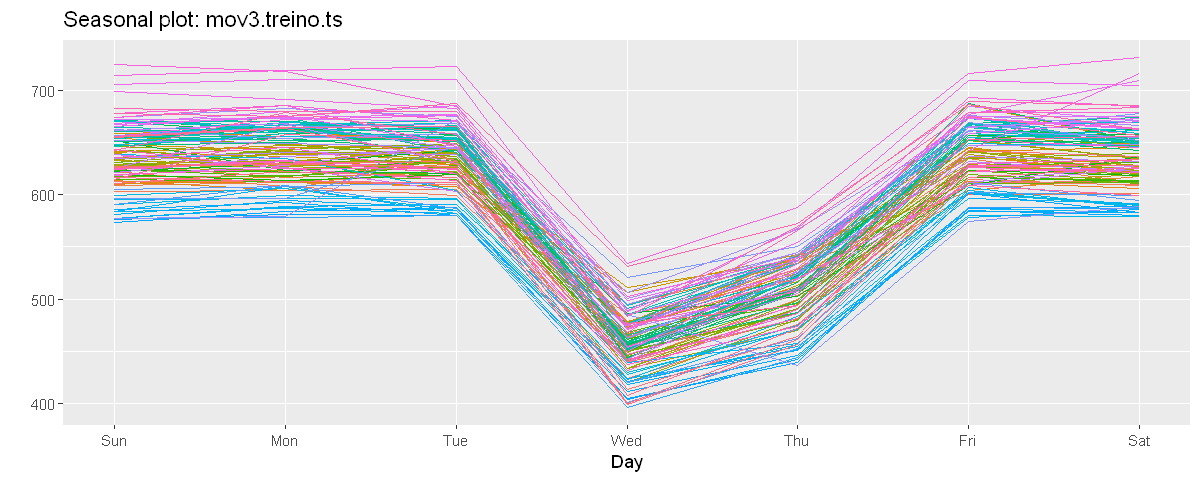

In [30]:
ggseasonplot(mov3.treino.ts) + theme(legend.position = "none") 

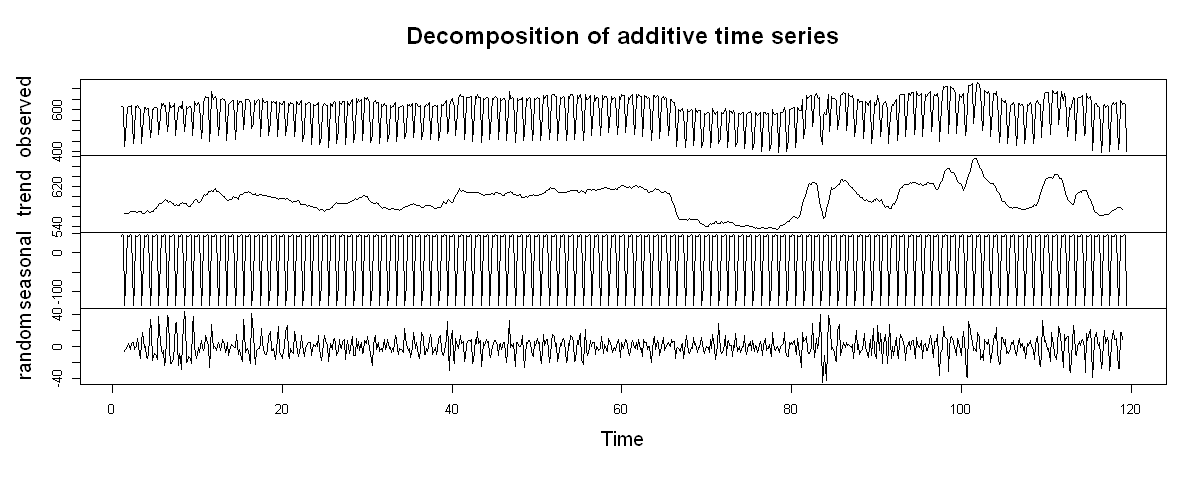

In [31]:
plot(decompose(mov3.treino.ts))

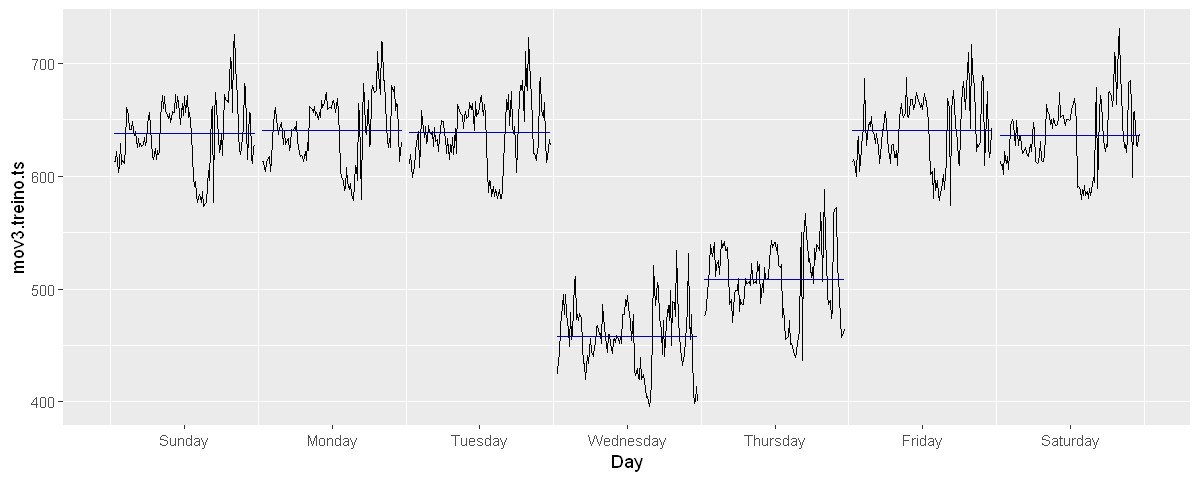

In [32]:
ggsubseriesplot(mov3.treino.ts)

In [33]:
accuracy(hw.mov3.predict, mov3.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,7.112904,42.86289,31.91398,0.7595466,5.341229,0.8994641,0.3683247


- #### 4ª janela

In [34]:
hw.mov4.forecast = HoltWinters(mov4.treino.ts)

In [35]:
hw.mov4.predict <- predict(hw.mov4.forecast,n.ahead = w4, prediction.interval = TRUE, level = 0.95)

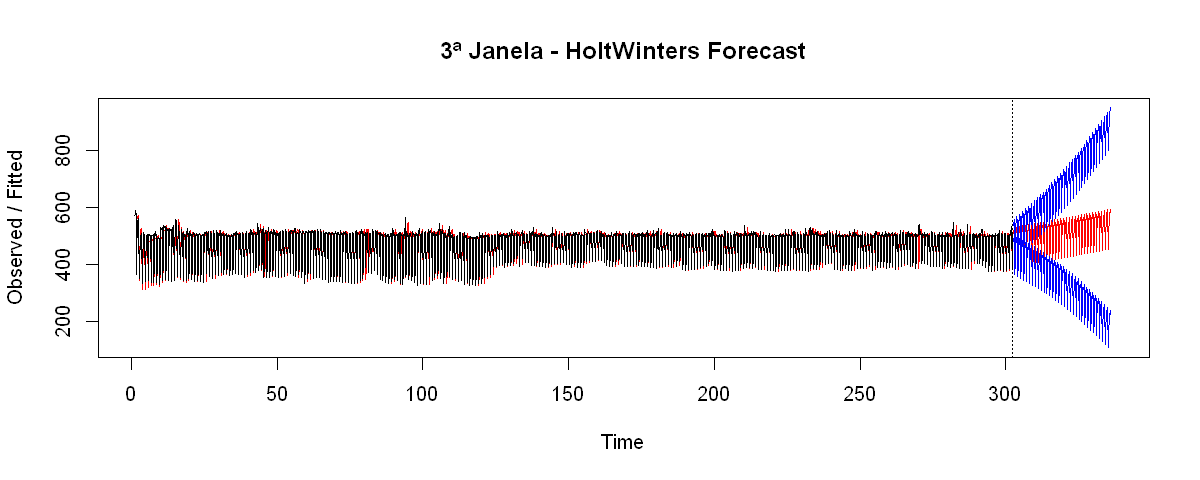

In [36]:
plot(hw.mov4.forecast, hw.mov4.predict, main = "3ª Janela - HoltWinters Forecast")

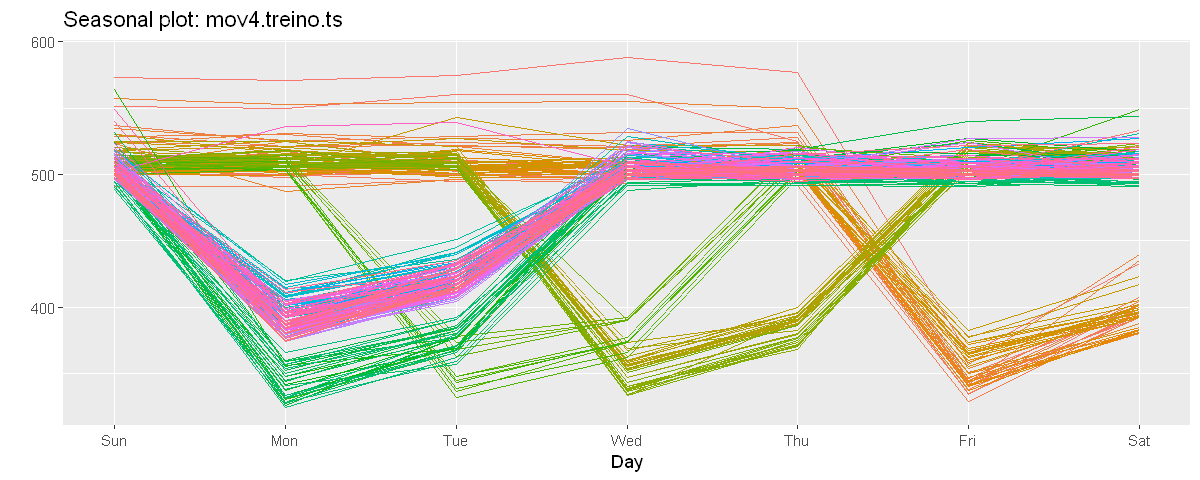

In [37]:
ggseasonplot(mov4.treino.ts) + theme(legend.position = "none") 

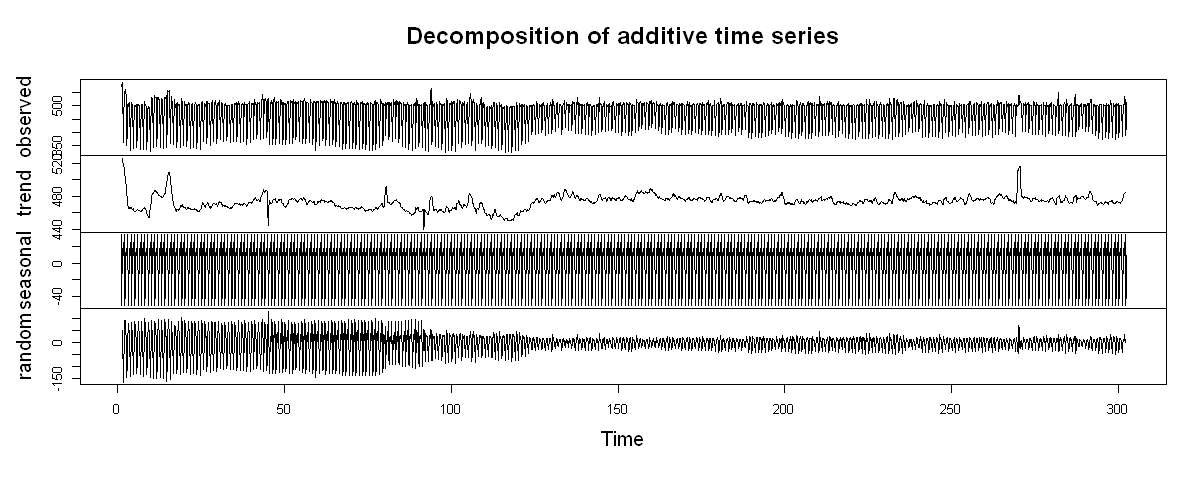

In [38]:
plot(decompose(mov4.treino.ts))

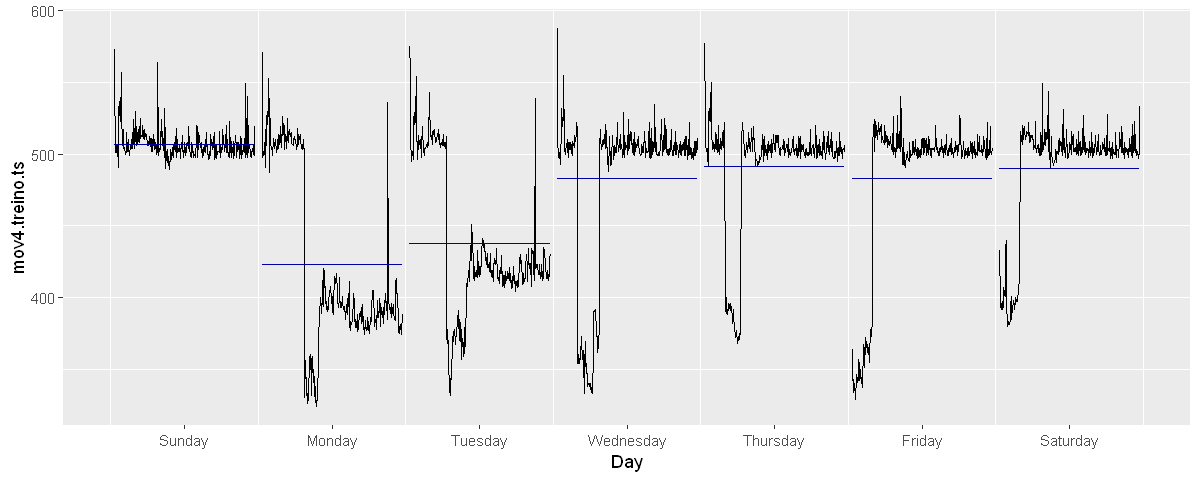

In [39]:
ggsubseriesplot(mov4.treino.ts)

In [40]:
accuracy(hw.mov4.predict, mov4.teste.ts, main = "4ª Janela - HoltWinters Forecast")

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-41.95736,75.19909,57.11429,-9.801775,12.79738,0.2199266,1.253422


- #### 5ª janela

In [41]:
hw.mov5.forecast = HoltWinters(mov5.treino.ts)

In [42]:
hw.mov5.predict <- predict(hw.mov5.forecast,n.ahead = w5, prediction.interval = TRUE, level = 0.95)

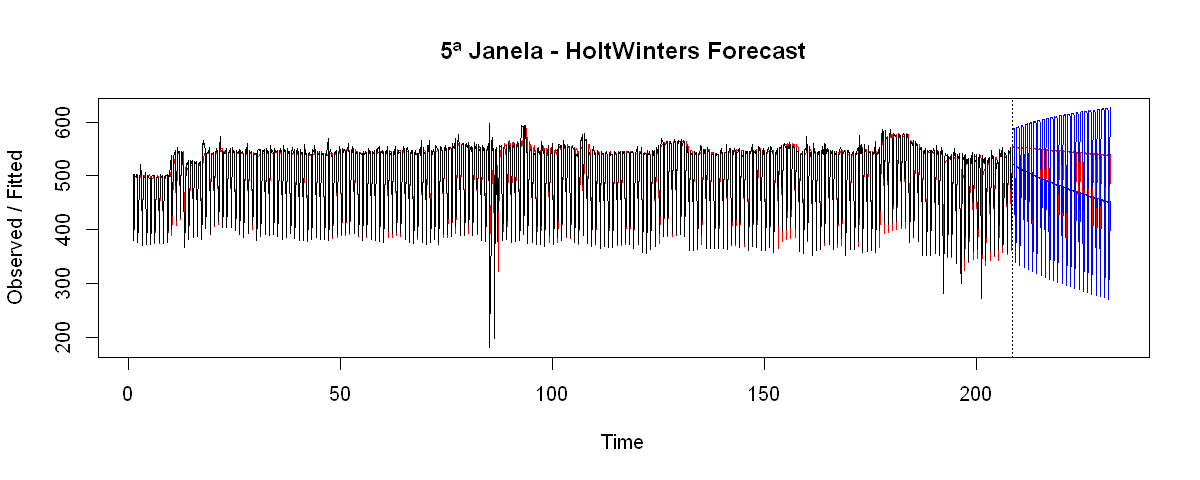

In [43]:
plot(hw.mov5.forecast, hw.mov5.predict, main = "5ª Janela - HoltWinters Forecast")

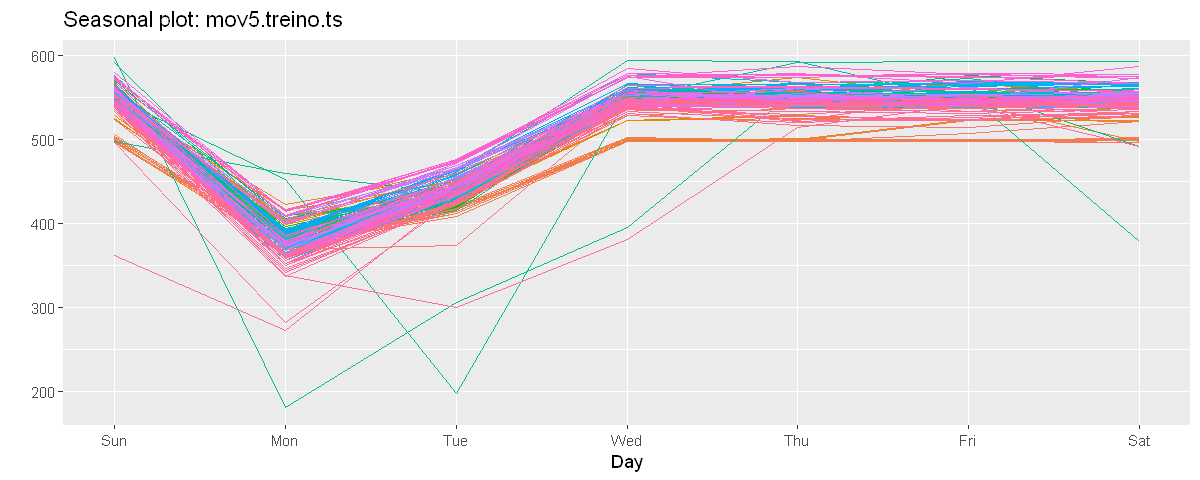

In [44]:
ggseasonplot(mov5.treino.ts) + theme(legend.position = "none") 

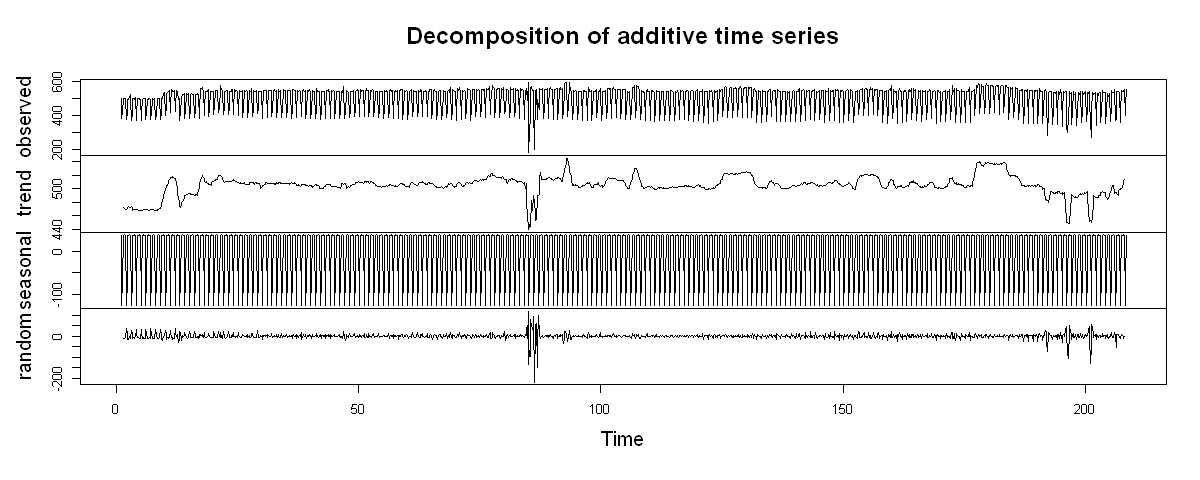

In [45]:
plot(decompose(mov5.treino.ts))

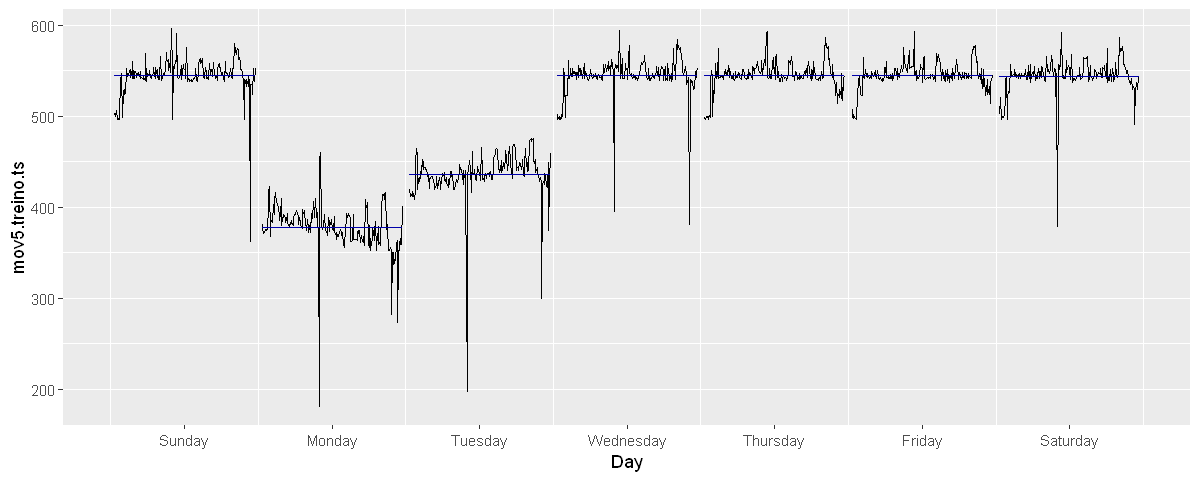

In [46]:
ggsubseriesplot(mov5.treino.ts)

In [47]:
accuracy(hw.mov5.predict, mov5.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-10.14494,24.373,15.43534,-2.46575,3.614663,0.4746629,0.2652275


### 2) NAIVE

O modelo de naive como diz o nome é um dos mais simples e é calculado através dos valores anteriores da série de tempo.

$$y_{t}=y_{t-1}$$

- #### 1ª janela

In [48]:
naive.mov1.forecast = snaive(mov1.treino.ts, h = w1)

In [49]:
nv.mov1.predict <- forecast(naive.mov1.forecast)

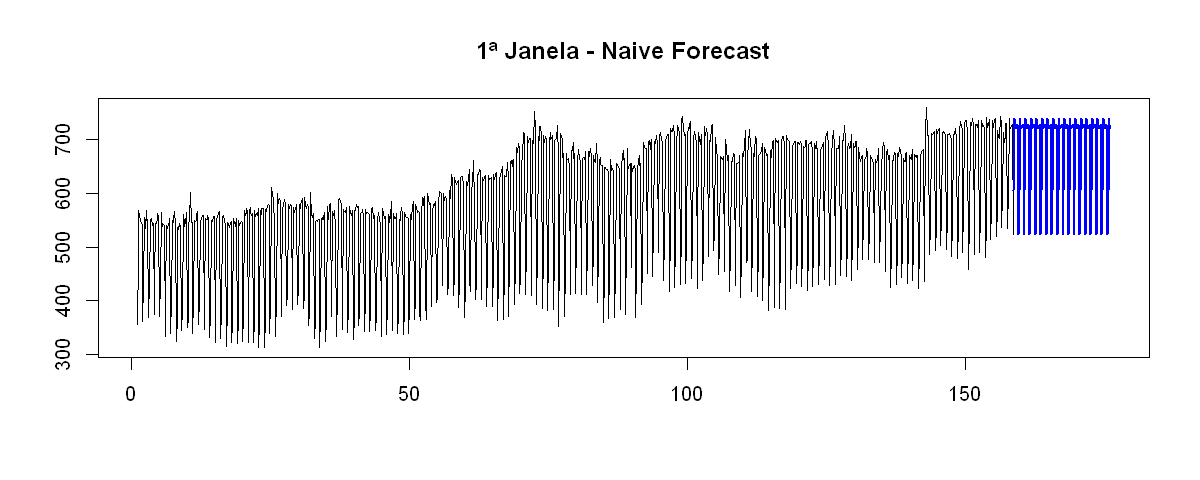

In [50]:
plot(nv.mov1.predict, main = "1ª Janela - Naive Forecast", PI = F)

In [51]:
accuracy(nv.mov1.predict, mov1.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,1.066545,24.36961,14.39745,0.0633754,2.666826,1.000000,0.2318399,NA
Test set,26.016260,47.38272,35.98374,3.1724103,4.867819,2.499314,0.6919824,0.3827986


- #### 2ª janela

In [52]:
naive.mov2.forecast = snaive(mov2.treino.ts, h = w2)

In [53]:
nv.mov2.predict <- forecast(naive.mov2.forecast)

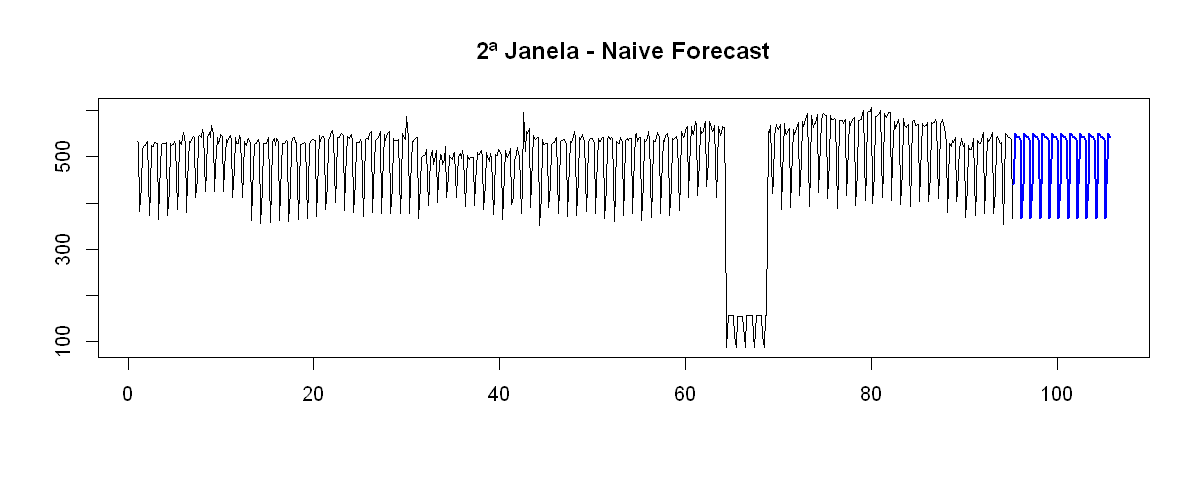

In [54]:
plot(nv.mov2.predict, main = "2ª Janela - Naive Forecast", PI = F)

In [55]:
accuracy(nv.mov2.predict, mov2.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.1225115,58.82965,18.10413,-2.309467,5.88805,1.000000,0.8085104,NA
Test set,-68.3424658,105.95172,71.79452,-19.789333,20.47523,3.965642,0.8908873,1.913534


- #### 3ª janela

In [56]:
naive.mov3.forecast = snaive(mov3.treino.ts, h = w3)

In [57]:
nv.mov3.predict <- forecast(naive.mov3.forecast)

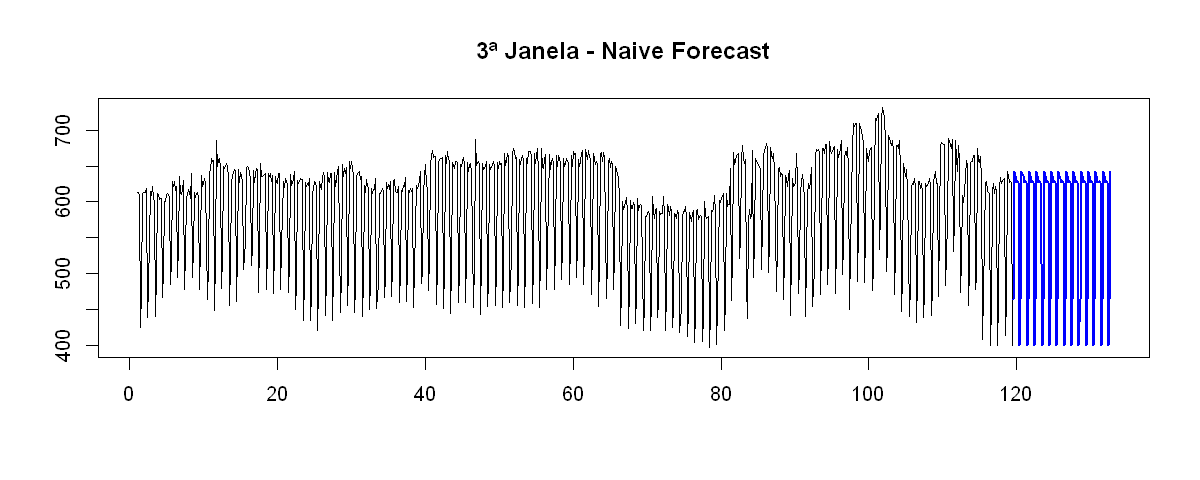

In [58]:
plot(nv.mov3.predict, main = "3ª Janela - Naive Forecast", PI = F)

In [59]:
accuracy(nv.mov3.predict, mov3.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.07897934,21.53623,14.46294,-0.05966062,2.474925,1.000000,0.6570665,NA
Test set,4.81521739,42.29516,31.48913,0.52167429,5.276146,2.177229,0.8909018,0.3662274


- #### 4ª janela

In [60]:
naive.mov4.forecast = snaive(mov4.treino.ts, h = w4)

In [61]:
nv.mov4.predict <- forecast(naive.mov4.forecast)

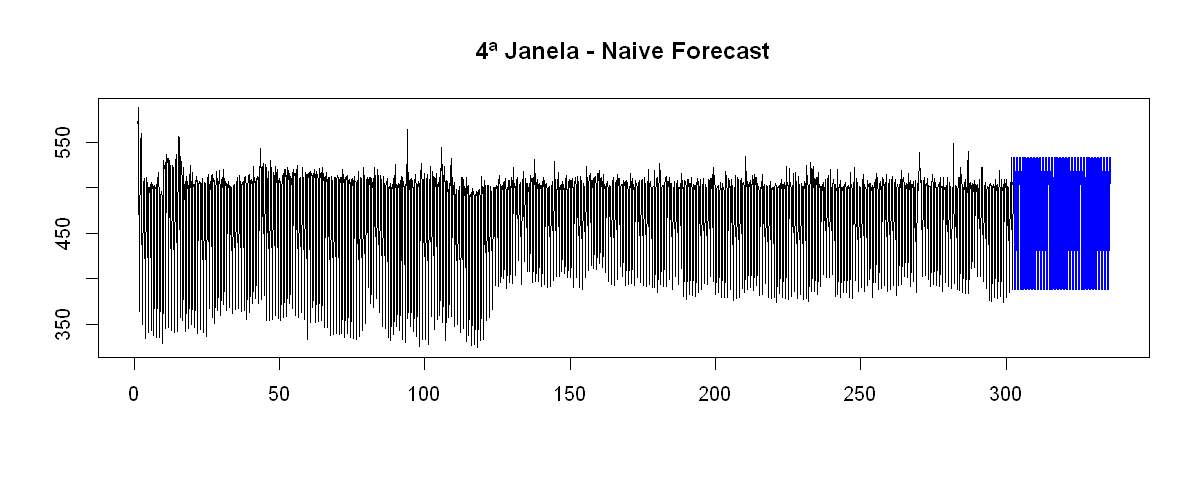

In [62]:
plot(nv.mov4.predict, main = "4ª Janela - Naive Forecast", PI = F)

In [63]:
accuracy(nv.mov4.predict, mov4.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.1378327,13.97373,7.147338,-0.07207024,1.539337,1.000000,0.33751398,NA
Test set,-8.7659574,58.91256,39.931915,-2.71088004,9.132050,5.586963,0.09412392,1.018593


- #### 5ª janela

In [64]:
naive.mov5.forecast = snaive(mov5.treino.ts, h = w5)

In [65]:
nv.mov5.predict <- forecast(naive.mov5.forecast)

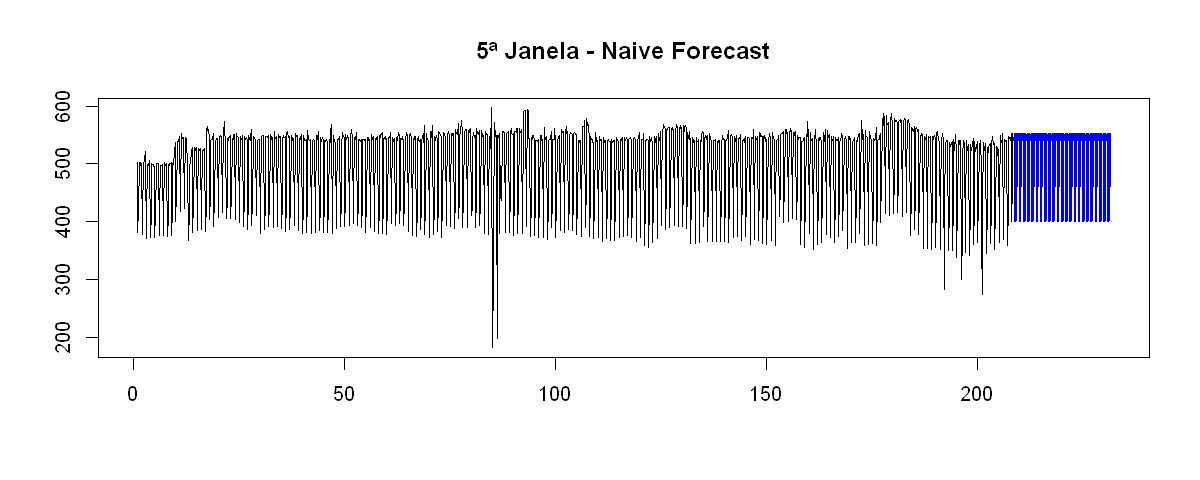

In [66]:
plot(nv.mov5.predict, main = "5ª Janela - Naive Forecast", PI = F)

In [67]:
accuracy(nv.mov5.predict, mov5.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.1998617,21.67471,9.415629,-0.119890,2.057028,1.000000,0.2535636,NA
Test set,-19.2422360,32.98108,20.881988,-4.834027,5.140042,2.217801,0.4517023,0.3725247


### 3) ARIMA e Metodologia Box e Jenkins

- #### 1ª janela

In [68]:
mov1.treino.arima <- auto.arima(mov1.treino.ts)
summary(mov1.treino.arima)

Series: mov1.treino.ts 
ARIMA(0,0,1)(1,1,0)[7] with drift 

Coefficients:
         ma1     sar1   drift
      0.2433  -0.1501  0.1525
s.e.  0.0292   0.0299  0.1092

sigma^2 estimated as 549:  log likelihood=-5015.2
AIC=10038.4   AICc=10038.43   BIC=10058.4

Training set error measures:
                       ME     RMSE      MAE        MPE     MAPE      MASE
Training set -0.005746297 23.32491 13.27693 -0.1233741 2.487304 0.9221726
                     ACF1
Training set -0.000723109


In [69]:
arima.mov1.predict <- forecast(mov1.treino.arima, h=w1)

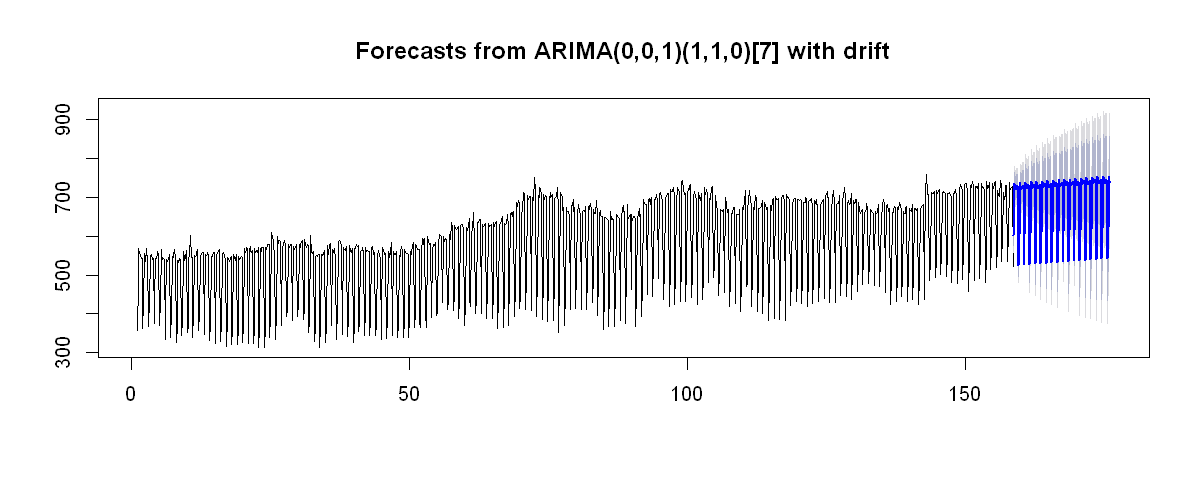

In [70]:
plot(arima.mov1.predict)

In [71]:
accuracy(arima.mov1.predict, mov1.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.005746297,23.32491,13.27693,-0.1233741,2.487304,0.9221726,-0.000723109,NA
Test set,17.701843671,41.67477,30.87515,1.9736216,4.238654,2.1444876,0.670218278,0.3431556


- #### 2ª janela

In [129]:
mov2.treino.arima <- auto.arima(mov2.treino.ts)
summary(mov2.treino.arima)

Series: mov2.treino.ts 
ARIMA(1,0,2)(0,1,1)[7] 

Coefficients:
         ar1      ma1      ma2     sma1
      0.9138  -0.0906  -0.0829  -0.4948
s.e.  0.0203   0.0447   0.0394   0.0389

sigma^2 estimated as 993.1:  log likelihood=-3179.12
AIC=6368.23   AICc=6368.32   BIC=6390.64

Training set error measures:
                     ME     RMSE      MAE        MPE     MAPE      MASE
Training set 0.02626189 31.25023 13.09558 -0.5700421 3.875761 0.7233474
                      ACF1
Training set -0.0007980883


In [130]:
arima.mov2.predict <- forecast(mov2.treino.arima, h=w2)

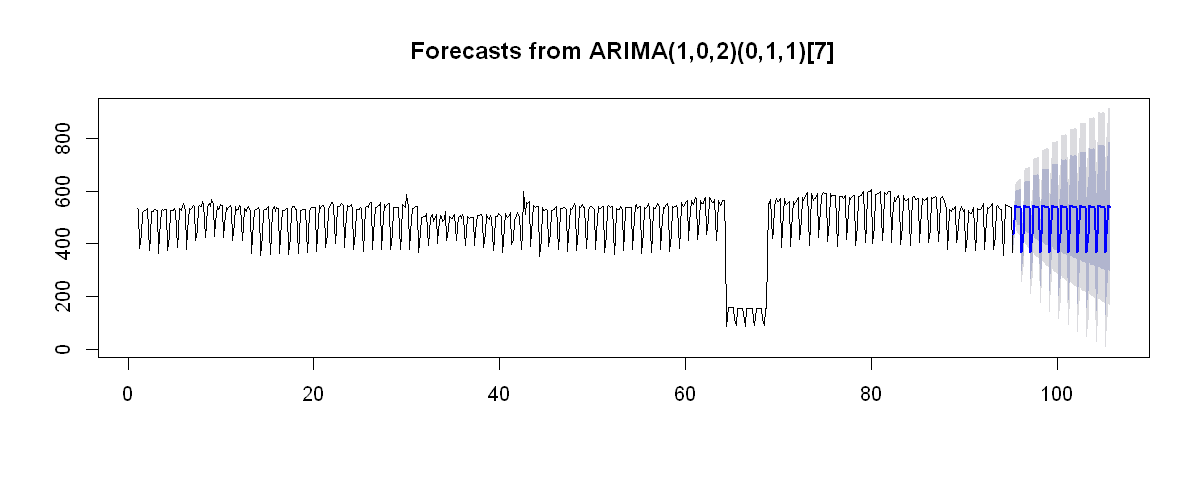

In [131]:
plot(arima.mov2.predict)

In [132]:
accuracy(arima.mov2.predict, mov2.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.02626189,31.25023,13.09558,-0.5700421,3.875761,0.7233474,-0.0007980883,NA
Test set,-65.55764190,103.95143,69.83340,-19.1296675,19.970630,3.8573177,0.8935584924,1.87317


- #### 3ª janela

In [133]:
mov3.treino.arima <- auto.arima(mov3.treino.ts)
summary(mov3.treino.arima)

Series: mov3.treino.ts 
ARIMA(1,0,2)(1,1,1)[7] 

Coefficients:
         ar1      ma1      ma2    sar1     sma1
      0.9215  -0.2293  -0.1895  0.2996  -0.9120
s.e.  0.0214   0.0411   0.0410  0.0503   0.0297

sigma^2 estimated as 194.4:  log likelihood=-3338.27
AIC=6688.54   AICc=6688.64   BIC=6716.81

Training set error measures:
                    ME     RMSE      MAE         MPE     MAPE      MASE
Training set 0.1681344 13.84256 9.918336 -0.04537043 1.737131 0.6857759
                      ACF1
Training set -0.0007959404


In [134]:
arima.mov3.predict <- forecast(mov3.treino.arima, h=w3)

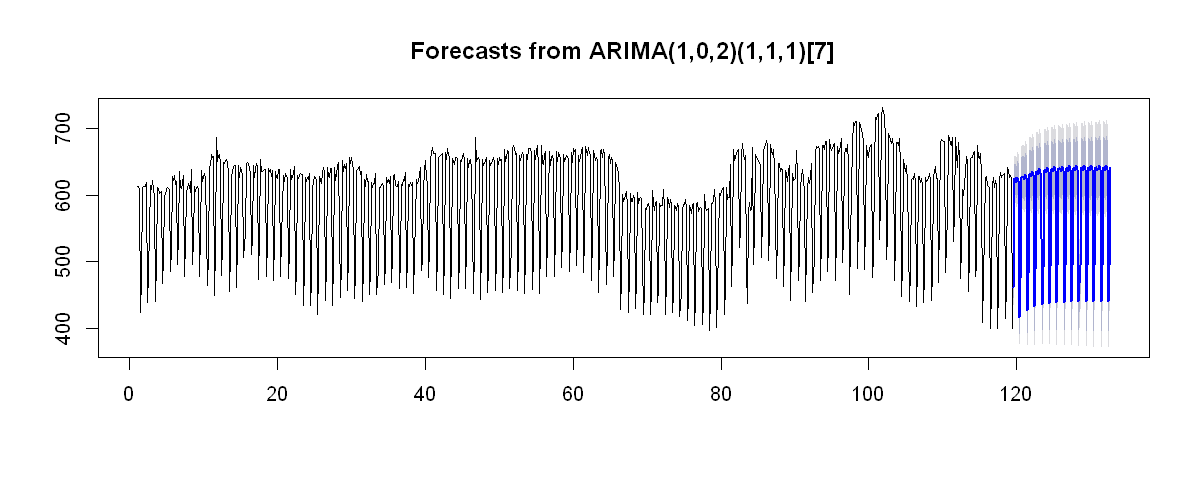

In [135]:
plot(arima.mov3.predict)

In [136]:
accuracy(arima.mov3.predict, mov3.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.1681344,13.84256,9.918336,-0.04537043,1.737131,0.6857759,-0.0007959404,NA
Test set,-6.8722532,44.20810,36.365451,-1.97085276,6.419053,2.5143885,0.8864085955,0.4017985


- #### 4ª janela

In [137]:
mov4.treino.arima <- auto.arima(mov4.treino.ts)
summary(mov4.treino.arima)

Series: mov4.treino.ts 
ARIMA(2,0,3)(2,1,1)[7] 

Coefficients:
          ar1      ar2     ma1     ma2     ma3    sar1    sar2     sma1
      -0.4458  -0.8056  0.8747  0.9053  0.3034  0.1252  0.0137  -0.4430
s.e.   0.0678   0.0769  0.0732  0.0884  0.0532  0.1568  0.0546   0.1567

sigma^2 estimated as 152.9:  log likelihood=-8273.43
AIC=16564.86   AICc=16564.95   BIC=16615.73

Training set error measures:
                     ME     RMSE      MAE         MPE     MAPE     MASE
Training set -0.1589206 12.32257 6.563058 -0.07274091 1.423743 0.918252
                    ACF1
Training set 0.006268421


In [138]:
arima.mov4.predict <- forecast(mov4.treino.arima, h=w4)

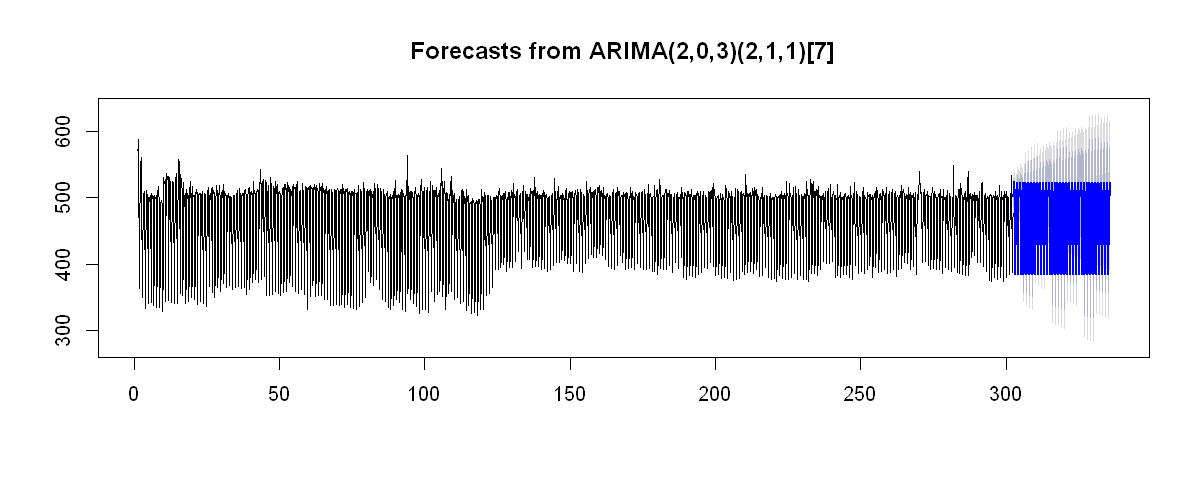

In [139]:
plot(arima.mov4.predict)

In [140]:
accuracy(arima.mov4.predict, mov4.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.1589206,12.32257,6.563058,-0.07274091,1.423743,0.918252,0.006268421,NA
Test set,-4.9591019,57.16895,38.086272,-1.88850817,8.728897,5.328735,0.062760904,0.9954339


- #### 5ª janela

In [141]:
mov5.treino.arima <- auto.arima(mov5.treino.ts)
summary(mov5.treino.arima)

Series: mov5.treino.ts 
ARIMA(2,0,3)(1,1,2)[7] 

Coefficients:
         ar1     ar2     ma1      ma2      ma3     sar1     sma1     sma2
      0.0433  0.8935  0.3352  -0.7057  -0.3008  -0.3735  -0.4129  -0.4814
s.e.  0.0228  0.0214  0.0341   0.0314   0.0283   0.1189   0.1096   0.0994

sigma^2 estimated as 243.9:  log likelihood=-6028.08
AIC=12074.16   AICc=12074.28   BIC=12121.65

Training set error measures:
                    ME     RMSE      MAE        MPE     MAPE      MASE
Training set 0.3124877 15.53505 7.425399 -0.1316733 1.665294 0.7886249
                     ACF1
Training set -0.003222908


In [142]:
arima.mov5.predict <- forecast(mov5.treino.arima, h=w5)

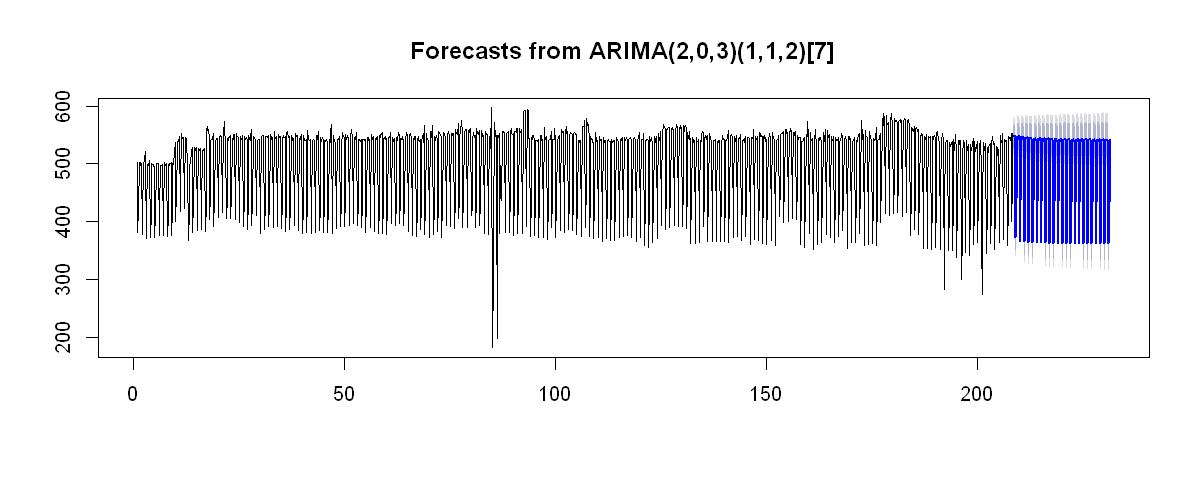

In [143]:
plot(arima.mov5.predict)

In [144]:
accuracy(arima.mov5.predict, mov5.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.3124877,15.53505,7.425399,-0.1316733,1.665294,0.7886249,-0.003222908,NA
Test set,-7.5342744,22.91357,12.988323,-1.9284974,3.094362,1.3794429,0.446952331,0.2506087


### 4) ARIMA-GARCH

- #### 1ª janela

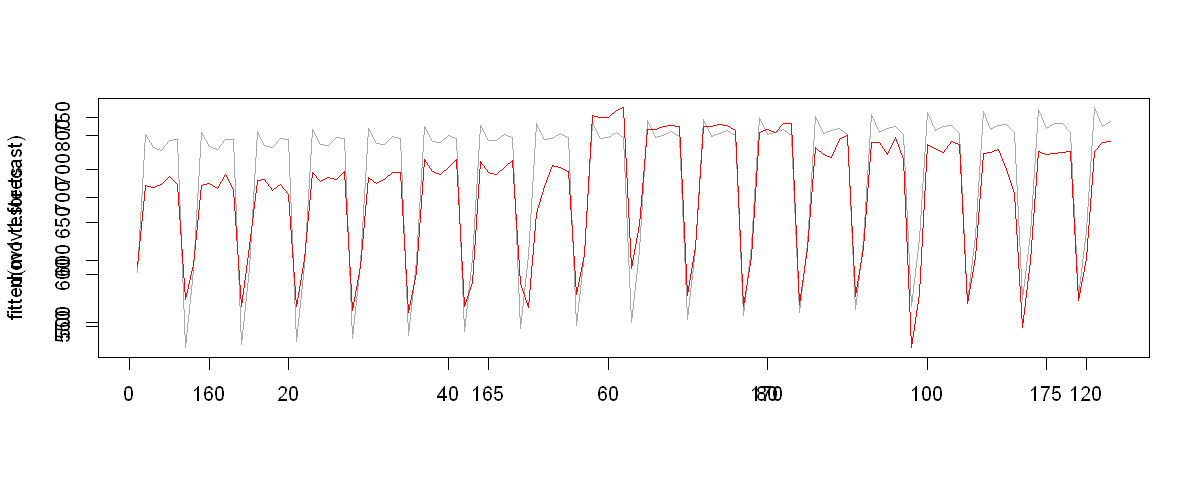

In [158]:
mov1.ug.spec <- rugarch::ugarchspec(mean.model = list(armaOrder = c(7, 7)),
                             variance.model = list(model = 'sGARCH',
                                                   garchOrder = c(1, 1),
                                                   submodel = NULL,
                                                   external.regressors = NULL,
                                                   variance.targeting = FALSE))
mov1.fit <- rugarch::ugarchfit(spec = mov1.ug.spec, data = mov1.treino.ts)

mov1.forecast = ugarchforecast(mov1.fit, n.ahead = w1)
plot(fitted(mov1.forecast), type='l', col='darkgrey',xlab = '')
par(new=TRUE)
plot(mov1.teste.ts, col = 'red',xlab = '')
ft = fitted(mov1.forecast)

In [159]:
print(mov1.teste.ts)

Time Series:
Start = c(158, 6) 
End = c(176, 2) 
Frequency = 7 
  [1] 590 720 717 721 735 721 537 593 720 723 715 737 714 527 622 728 729 712
 [19] 722 705 527 602 740 727 732 729 743 520 591 732 723 729 741 740 516 580
 [37] 761 743 738 749 761 526 565 758 741 737 749 760 563 524 675 719 752 749
 [55] 743 545 609 832 829 828 840 844 587 657 810 809 814 816 814 544 620 815
 [73] 815 817 816 808 526 607 804 809 805 819 819 530 619 781 770 764 793 800
 [91] 543 621 789 789 770 796 762 460 547 786 779 772 791 786 531 605 771 773
[109] 777 745 707 493 600 775 769 771 773 774 536 603 775 788 791


In [160]:
ft.ts = ts(as.data.frame(ft)[,1], start=c(158,6) , frequency = 7)
accuracy(ft.ts, mov1.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,14.77674,44.58799,33.96256,1.377801,4.79092,0.574896,0.3707872


- #### 2ª janela

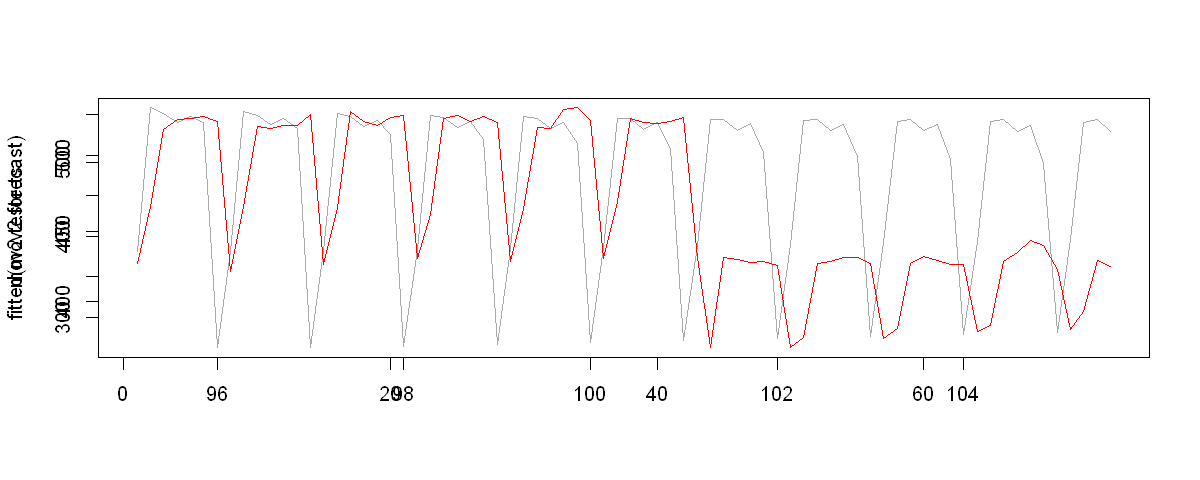

In [184]:
mov2.ug.spec <- rugarch::ugarchspec(mean.model = list(armaOrder = c(7, 7)),
                             variance.model = list(model = 'sGARCH',
                                                   garchOrder = c(0,1),
                                                   submodel = NULL,
                                                   external.regressors = NULL,
                                                   variance.targeting = FALSE))
mov2.fit <- rugarch::ugarchfit(spec = mov2.ug.spec, data = mov2.treino.ts)

mov2.forecast = ugarchforecast(mov2.fit, n.ahead = w2)
plot(fitted(mov2.forecast), type='l', col='darkgrey',xlab = '')
par(new=TRUE)
plot(mov2.teste.ts, col = 'red',xlab = '')
ft = fitted(mov2.forecast)

In [177]:
print(mov2.teste.ts)

Time Series:
Start = c(95, 2) 
End = c(105, 5) 
Frequency = 7 
 [1] 366 436 532 544 545 548 541 356 436 535 533 537 536 550 365 435 554 541 537
[20] 546 549 372 427 545 549 541 547 540 369 434 534 533 556 558 543 372 443 545
[39] 540 539 541 546 374 262 373 371 368 369 364 263 275 366 369 374 374 366 274
[58] 286 366 375 370 365 365 282 290 369 380 394 389 359 285 307 370 363


In [178]:
ft.ts = ts(as.data.frame(ft)[,1], start=c(95,2) , frequency = 7)
accuracy(ft.ts, mov2.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-72.59116,134.3192,103.596,-22.74022,28.42599,0.4799726,2.351045


- #### 3ª janela

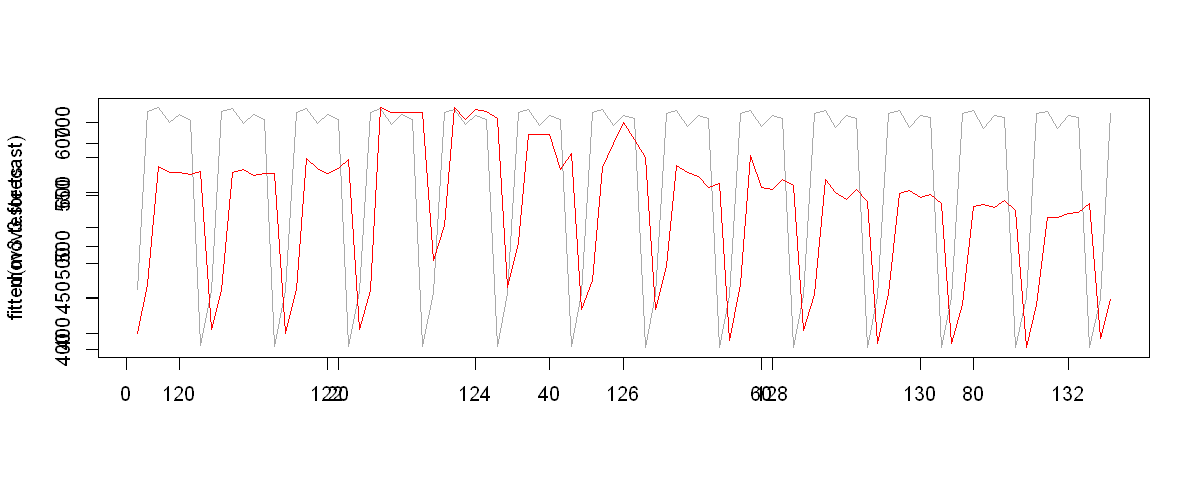

In [165]:
mov3.ug.spec <- rugarch::ugarchspec(mean.model = list(armaOrder = c(7, 7)),
                             variance.model = list(model = 'sGARCH',
                                                   garchOrder = c(1, 1),
                                                   submodel = NULL,
                                                   external.regressors = NULL,
                                                   variance.targeting = FALSE))
mov3.fit <- rugarch::ugarchfit(spec = mov3.ug.spec, data = mov3.treino.ts)

mov3.forecast = ugarchforecast(mov3.fit, n.ahead = w3)
plot(fitted(mov3.forecast), type='l', col='darkgrey',xlab = '')
par(new=TRUE)
plot(mov3.teste.ts, col = 'red',xlab = '')
ft = fitted(mov3.forecast)

In [166]:
print(mov3.teste.ts)

Time Series:
Start = c(119, 4) 
End = c(132, 5) 
Frequency = 7 
 [1] 400 470 637 629 628 626 630 406 461 628 633 625 627 627 401 463 648 634 627
[20] 634 647 406 461 720 714 713 713 714 504 553 720 703 718 715 705 466 529 682
[39] 682 683 633 655 434 475 636 669 700 676 650 435 496 639 629 623 608 613 390
[58] 470 652 608 604 619 610 405 456 619 600 591 605 588 386 457 599 603 593 597
[77] 584 387 442 580 583 579 589 575 380 441 565 565 571 572 585 394 448


In [169]:
ft.ts = ts(as.data.frame(ft)[,1], start=c(119, 4) , frequency = 7)
accuracy(ft.ts, mov3.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,7.496486,113.7034,82.41731,-1.042983,14.92013,0.1001223,1.107574


- #### 4ª janela

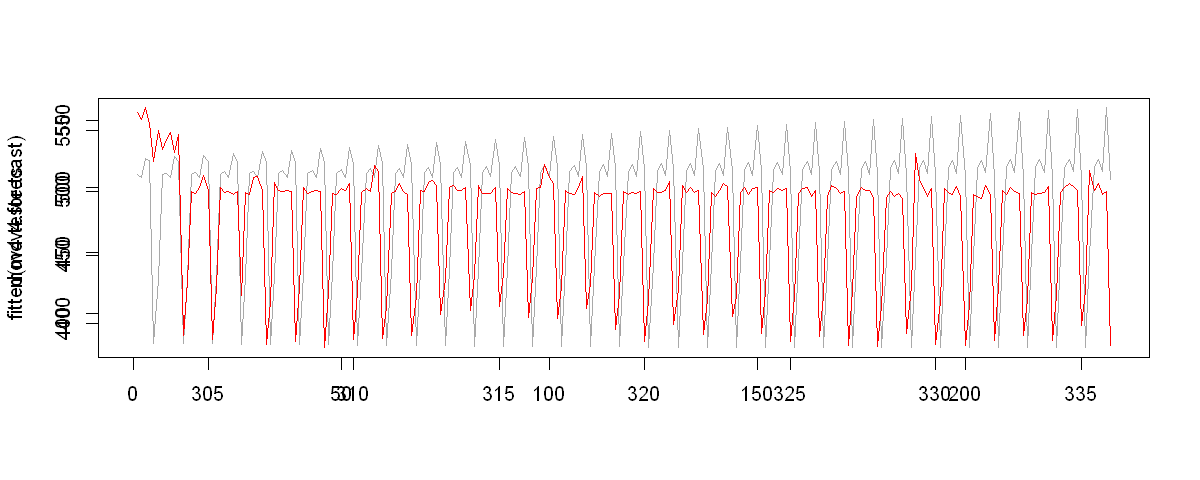

In [152]:
mov4.ug.spec <- rugarch::ugarchspec(mean.model = list(armaOrder = c(7, 7)),
                             variance.model = list(model = 'sGARCH',
                                                   garchOrder = c(1, 1),
                                                   submodel = NULL,
                                                   external.regressors = NULL,
                                                   variance.targeting = FALSE))
mov4.fit <- rugarch::ugarchfit(spec = mov4.ug.spec, data = mov4.treino.ts)

mov4.forecast = ugarchforecast(mov4.fit, n.ahead = w4)
plot(fitted(mov4.forecast), type='l', col='darkgrey',xlab = '')
par(new=TRUE)
plot(mov4.teste.ts, col = 'red',xlab = '')
ft = fitted(mov4.forecast)

In [153]:
print(mov4.teste.ts)

Time Series:
Start = c(302, 5) 
End = c(336, 1) 
Frequency = 7 
  [1] 564 559 568 555 524 550 534 542 548 532 546 382 426 500 498 503 513 501
 [19] 379 421 503 499 500 497 500 415 499 497 511 512 501 375 410 507 501 500
 [37] 501 500 377 421 503 498 500 501 500 372 417 498 497 502 501 506 379 417
 [55] 499 502 500 521 516 380 405 498 500 506 500 497 382 414 501 500 507 509
 [73] 505 399 428 503 505 501 501 503 403 431 505 498 498 498 503 406 433 502
 [91] 499 498 497 500 397 429 502 503 522 511 506 396 421 501 498 497 503 512
[109] 404 424 499 496 498 498 498 387 416 500 497 499 498 500 377 411 502 499
[127] 499 501 508 391 420 505 499 503 499 501 383 412 499 496 501 506 504 398
[145] 414 499 503 497 502 503 384 418 501 499 502 501 502 377 414 498 502 503
[163] 496 501 381 415 496 505 502 498 500 374 419 496 503 501 501 495 373 406
[181] 495 500 496 498 494 384 422 531 510 503 496 502 375 410 502 499 497 504
[199] 496 374 407 497 496 494 505 497 378 421 501 497 503 500 498 382 412 499


In [170]:
ft.ts = ts(as.data.frame(ft)[,1], start=c(302, 5) , frequency = 7)
accuracy(ft.ts, mov4.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-86.37448,143.2882,131.0836,-19.87449,28.69061,0.4056964,2.692282


- #### 5ª janela

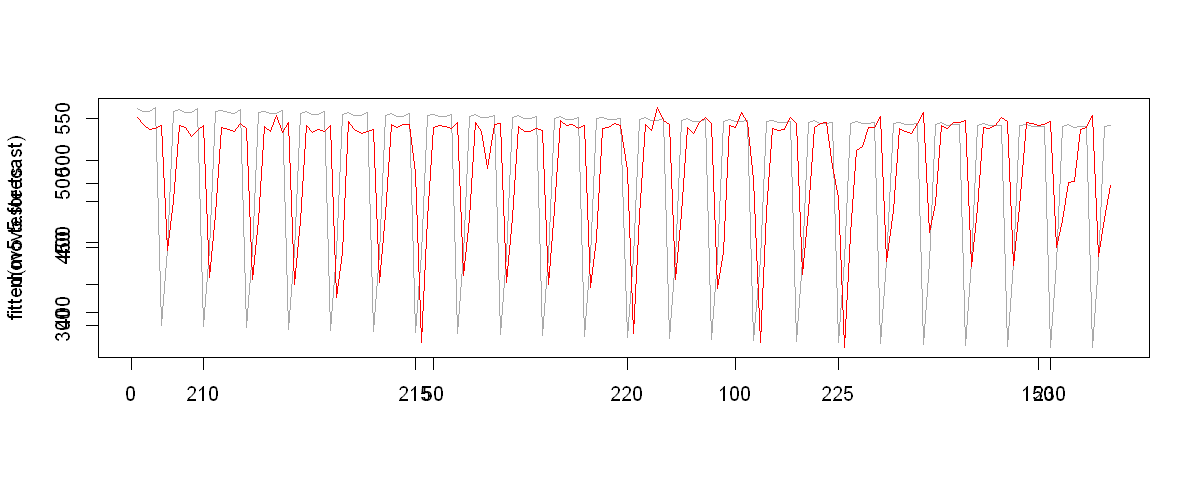

In [155]:
mov5.ug.spec <- rugarch::ugarchspec(mean.model = list(armaOrder = c(7, 7)),
                             variance.model = list(model = 'sGARCH',
                                                   garchOrder = c(1, 1),
                                                   submodel = NULL,
                                                   external.regressors = NULL,
                                                   variance.targeting = FALSE))
mov5.fit <- rugarch::ugarchfit(spec = mov5.ug.spec, data = mov5.treino.ts)

mov5.forecast = ugarchforecast(mov5.fit, n.ahead = w5)
plot(fitted(mov5.forecast), type='l', col='darkgrey',xlab = '')
par(new=TRUE)
plot(mov5.teste.ts, col = 'red',xlab = '')
ft = fitted(mov5.forecast)

In [156]:
print(mov5.teste.ts)

Time Series:
Start = c(208, 4) 
End = c(231, 4) 
Frequency = 7 
  [1] 552 543 537 538 542 391 451 542 539 528 536 542 358 434 540 537 535 544
 [19] 538 356 427 541 535 554 533 546 350 427 542 533 537 535 542 334 388 547
 [37] 537 532 534 537 352 434 543 539 543 543 485 280 430 539 542 541 538 546
 [55] 360 429 545 534 490 543 544 352 431 541 535 534 538 536 350 440 548 542
 [73] 543 538 542 346 405 538 539 544 542 487 290 433 543 536 563 548 543 356
 [91] 435 539 532 546 551 544 345 388 542 540 558 546 476 280 437 538 536 537
[109] 552 544 362 439 540 544 545 492 455 273 410 512 517 540 540 553 377 439
[127] 538 534 532 544 558 413 447 542 538 545 545 548 372 441 540 538 542 552
[145] 547 373 443 545 544 542 543 547 394 427 473 474 537 540 554 384 430 469


In [171]:
ft.ts = ts(as.data.frame(ft)[,1], start=c(208, 4) , frequency = 7)
accuracy(ft.ts, mov5.teste.ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-73.81534,131.2497,108.1681,-17.94604,24.6191,-0.02546985,1.268187


### 5) MAPE e TIC

### 6) Conlcusoes